In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.cluster.hierarchy as hac

import glob

import struct

import pandas

Как помочь нам разобрать протокол?

Вот пример как это делается в простом случае.

Есть устройство на чипе HS1527 и к нему даже нашелся datasheet: http://sc-tech.cn/en/hs1527.pdf

Есть Wiren Board c rfsniffer. Первое что мы делаем, записываем дамп. 

`{some path}/wb-homa-rfsniffer -W`

Когда запись произойдет, останавливаем программу и начинаем изучать данные, сохраненные в `.rcf` файле.


In [20]:
# takes filename
# open file, read binary data
# returns numpy.array of impulses (positive integer)
# and pauses (negative integer)
def file_to_data(filename):
    pic = open(filename, "rb")
    data = []
    while True:
        buf = pic.read(4)
        if not buf or len(buf) != 4:
            break
        sign = (1 if buf[3] == 1 else -1)
        #print(len(buf))
        buf = bytes(buf[:3] + bytes([0]))
        #print(len(buf))
        data.append(sign * struct.unpack('i', buf)[0])
    return np.array(data)

# takes files' mask
# returns numpy.array of data
def files_to_data(mask):
    # откуда брать дампы
    filenames = glob.glob(mask)
    
    print("%d files found" % len(filenames))

    datas = []

    # посмотрим файлики с дампами, преобразуем в импульсы
    for name in filenames:
        datas.append(file_to_data(name))

    return np.concatenate(datas)


In [21]:
# читаем информацию
data = files_to_data("./*.rcf")

2 files found


Посмотрим на гистограммы длин импульсов и пауз

In [27]:
# show histogramm of lengthes
# ignore lengthes that is greater than max_len
# (0.9-fractile) * 1.3 by default
def show_hist(data, title, threshold=0.02, max_len=None):
    if max_len == None:
        k = int(len(data) * (1 - threshold))
        data = np.partition(data, k)
        max_len = int(data[k] * 1.3)    
    data = data[data <= max_len]
    hist, bins = np.histogram(data)
    #width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    #plt.bar(center, hist, align='center', width=width)
    plt.hist(data, bins = 100)
    #plt.yscale("log")
    plt.title(title)
    plt.xlim([0, max_len])
    plt.show()

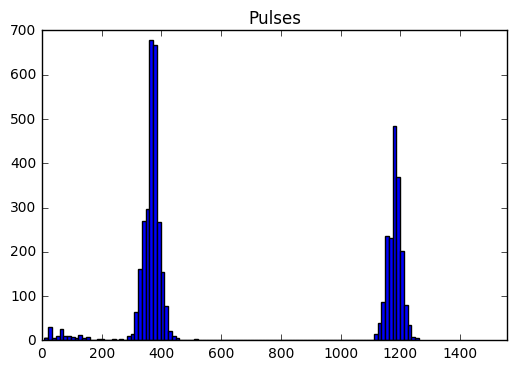

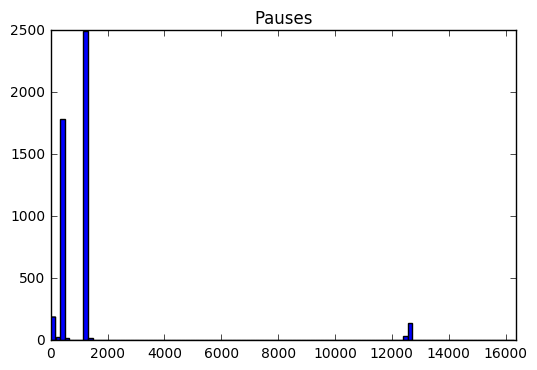

In [30]:
show_hist(data[data > 0], "Pulses", threshold=0.1)
show_hist(-data[data < 0], "Pauses", threshold=0.02) # обращаем внимание на непримечательный пик справа

Немножко удобной автоматики для группирования сигналов по длинам

In [34]:
# data - list of signals
# threshold - length of minimal distance between clusters
# output format list of such structures 
# (letter, lower, upper, count) giving information about group
def clusterize_signals(data, threshold = 100, threshold_count = 10):
    groups = []

    for signals in (data[data > 0], data[data < 0]):
        signals_color = hac.fclusterdata(X = np.matrix([signals]).T, 
                                  criterion='distance', t = threshold)
        for i in range(1, 10000):
            group = signals[signals_color == i]
            if (len(group) == 0):
                break
            #print(group)
            bounds = (abs(int(group.mean())), group.min(), group.max(), len(group))
            if len(group) > threshold_count:
                groups.append(bounds)

    groups = sorted(groups)

    cur_impulse_code = ord('A')
    cur_pause_code = ord('a')

    for i in range(len(groups)):
        mean, lower, upper, count = groups[i]
        code = 0
        if (lower > 0):
            code = cur_impulse_code
            cur_impulse_code += 1
            groups[i] = (chr(code), 
                         max(1, int(lower - threshold / 3)), 
                         int(upper + threshold / 3), 
                         count)
        else:
            code = cur_pause_code
            cur_pause_code += 1
            groups[i] = (chr(code), 
                         int(lower - threshold / 3), 
                         min(int(upper + threshold / 3), -1), 
                         count)
    return groups

# делаем группы
groups = clusterize_signals(data, threshold = 100, threshold_count = 15)
print("(letter, lower, upper, count)")
print("\n".join(map(str, groups)))

(letter, lower, upper, count)
('A', 1, 917, 2869)
('a', -563, -1, 2014)
('B', 985, 1295, 1794)
('b', -1403, -1110, 2514)
('c', -12727, -12441, 179)


Получили группы сигналов

In [35]:
groups = list(filter(lambda x: x[0] in {'A', 'B', 'a', 'b', 'c'}, groups))
groups

[('A', 1, 917, 2869),
 ('a', -563, -1, 2014),
 ('B', 985, 1295, 1794),
 ('b', -1403, -1110, 2514),
 ('c', -12727, -12441, 179)]

In [37]:
# All the same but in a table
data_frame = pandas.DataFrame([(lower, upper, count) for letter, lower, upper, count in groups], 
                              index=[letter for letter, lower, upper, count in groups],
            
                              columns=['Lower length', 'Upper length', 'count of signals'])
data_frame.insert(1, "Type", ["impulse" if lower > 0 else "pause" for c, lower, upper, count in groups])
data_frame = data_frame.sort_index()
#data_frame = data_frame.pivot_table(index='Letter')
data_frame

,Lower length,Type,Upper length,count of signals
A,1,impulse,917,2869
B,985,impulse,1295,1794
a,-563,pause,-1,2014
b,-1403,pause,-1110,2514
c,-12727,pause,-12441,179


Заменим каждый сигнал буквой, обозначающей его группу. Так зачастую удобнее

In [39]:
# finds signal in groups
# returns a corresponding letter
def decode_signal(x, groups):
    for c, lower, upper, group in groups:
        if lower <= x <= upper:
            return c
    return "?"

# decode list of signals
# each signal is decoded separately
def decode_signals(data, groups):
    return [decode_signal(signal, groups) for signal in data]

# decoded signals
data_letters = decode_signals(data, groups)

print("Decoded (characters): ", "".join(data_letters))
    

Decoded (characters):  ??bBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBaAbBaAbBaAbBaAbAcAbAbBaAbAbBaAbAbAbBaBaAbBaBaAbAbBa

Это уже почти человеко-читаемо. Сейчас смотрим в даташит и видим, что `'Ac'` - импульс и длинная пауза - это преамбула. А `'Ab'` и `'Ba'` задают 0 и 1.

In [50]:
# заменим пары символов на их смысл
data_1 = "".join(data_letters).replace('Ac', 'P').replace('Ab', '0').replace('Ba', '1')
print(data_1[:300])

??b1000110110010101010P001001000110110010101010P001001000110110010101010P001001000110110010101010P001001000110110010101010P001001000110110010101010P001001000110110010101010P001001000110110010101010P001001000110110010101010P001001000110110010101010P001001000110110010101010P001001000110110010101010P00


Здесь уже хорошо видно периодичные 'P'-шки. Поделим всю строку на пакеты.

In [66]:
data = list(filter(lambda x: len(x) == 24, data_1.split('P')))
print(data[:5])
data = set(data)
print(data)

['001001000110110010101010', '001001000110110010101010', '001001000110110010101010', '001001000110110010101010', '001001000110110010101010']
{'001001000110110010101010', '001001000110110010100110'}


Видим, что подряд идет помногу одинаковых пакетов. В снятых мною дампах это сигналы от датчика движения при двух разных конфигурациях джамперов

In [67]:
# разделяем на непосредственно сообщение и флаги D0-D3
data_pairs = list(map(lambda x: (int(x[:20], 2), int(x[20:], 2)), data))
data_pairs
# или в 16-ричной
data_pairs16 = list(map(lambda x: (hex(x[0]), hex(x[1])), data_pairs16))
data_pairs


[(149194, 10), (149194, 6)]

Готово!

In [62]:
int('100'[:2], 2)

2